# Using GradCAM to identify adveserial attacks 
## FGSM implimentation from : https://www.tensorflow.org/tutorials/generative/adversarial_fgsm 

In [79]:
from model import load_model
from image_utils import imagenet_utils
import cv2 ,matplotlib.pyplot as plt
import numpy as np
from explanation_models import gradcam

In [80]:
# orig_img,img=imagenet_utils.load_test_img("both.png")
orig_img,img=imagenet_utils.load_test_img('ILSVRC2012_img_val/ILSVRC2012_val_00000495.JPEG')

In [81]:
test=load_model('VGG16')
model=test.model
input_dim=test.input_dim
layer_name='block5_conv3'

In [82]:
import tensorflow as tf
probs=model.predict(img)
print(tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=5))
print(np.argsort(-probs)[0][:5])

[[('n02489166', 'proboscis_monkey', 0.9987185), ('n02486261', 'patas', 0.0007763076), ('n02487347', 'macaque', 0.00049237185), ('n02488291', 'langur', 5.923407e-06), ('n02493509', 'titi', 4.9267196e-06)]]
[376 371 373 374 380]


Text(0.5, 1.0, 'eps:0,proboscis_monkey(99.87%)')

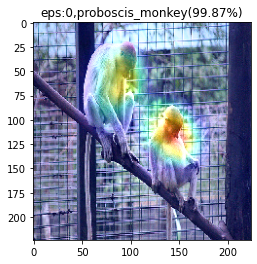

In [104]:
g= gradcam(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
heatmap_colormap,overlayed_img_orig_gc=imagenet_utils.overlay_heatmap(orig_img,heatmap)
plt.imshow(overlayed_img_orig_gc)
_,name,confidence=tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]
plt.title('eps:{},{}({:.2f}%)'.format(0,name, confidence*100))

In [84]:

def create_adversarial_pattern(input_image, input_label):
    input_image = tf.cast(input_image, tf.float32)
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)

    return signed_grad

In [94]:
boxer=376
label = tf.one_hot(boxer, probs.shape[-1])
label = tf.reshape(label, (1, probs.shape[-1]))
perturbations = create_adversarial_pattern(img, label)


In [95]:
eps=0.999
adv_x = img + eps*perturbations

In [96]:
probs2=model.predict(adv_x)
print(tf.keras.applications.mobilenet_v2.decode_predictions(probs2, top=5))
print(np.argsort(-probs2)[0][:5])


[[('n02487347', 'macaque', 0.79591876), ('n02486261', 'patas', 0.17150944), ('n02489166', 'proboscis_monkey', 0.021361955), ('n02493509', 'titi', 0.0033482036), ('n02484975', 'guenon', 0.0024013207)]]
[373 371 376 380 370]


Text(0.5, 1.0, 'eps:0.999,macaque(79.59%)')

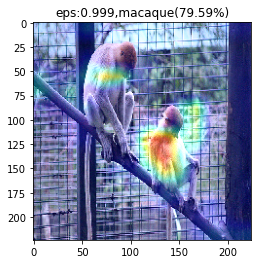

In [109]:
heatmap=g.get_heatmap(adv_x)
heatmap_colormap,overlayed_img_new_class=imagenet_utils.overlay_heatmap(orig_img,heatmap)
plt.imshow(overlayed_img_new_class)
_,name2,confidence2=tf.keras.applications.mobilenet_v2.decode_predictions(probs2, top=1)[0][0]
plt.title('eps:{},{}({:.2f}%)'.format(eps,name2, confidence2*100))

Text(0.5, 1.0, 'eps:0.999,proboscis_monkey(2.14%)')

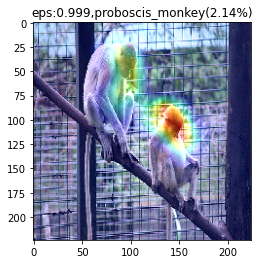

In [100]:
orig_label=376
heatmap=g.get_heatmap(adv_x,orig_label)
heatmap_colormap,overlayed_img_orig_class=imagenet_utils.overlay_heatmap(orig_img,heatmap)
plt.imshow(overlayed_img_orig_class)
plt.title('eps:{},{}({:.2f}%)'.format(eps,'proboscis_monkey', probs2[0][orig_label]*100))

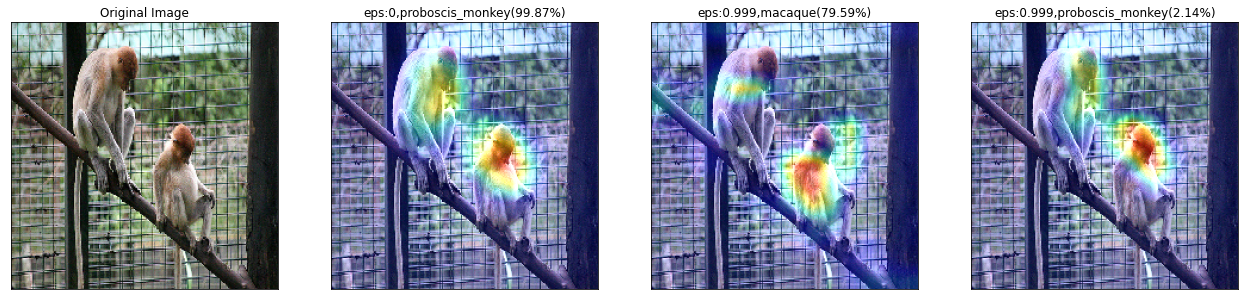

In [113]:
f, axarr = plt.subplots(1,4)
f = plt.gcf()
f.set_size_inches(22,15)
for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])
axarr[0].imshow(orig_img)
axarr[0].title.set_text('Original Image')
axarr[1].imshow(overlayed_img_orig_gc)
axarr[1].title.set_text('eps:{},{}({:.2f}%)'.format(0,name, confidence*100))
axarr[2].imshow(overlayed_img_new_class)
axarr[2].title.set_text('eps:{},{}({:.2f}%)'.format(eps,name2, confidence2*100))
axarr[3].imshow(overlayed_img_orig_class)
axarr[3].title.set_text('eps:{},{}({:.2f}%)'.format(eps,'proboscis_monkey', probs2[0][orig_label]*100))

plt.savefig('Results/Effect_of_Noise1.jpeg', dpi=200)